<a href="https://colab.research.google.com/github/c90x/loan_prediction/blob/main/loan_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loan Dataset - Lab

Original Dataset:

## Dependencies

In [1]:
import re
from pathlib import Path

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Configure theme

In [3]:
plt.style.use('dark_background')

**Download** dataset from Kaggle

In [4]:
import kagglehub

# Download latest version
path = Path(kagglehub.dataset_download("ranadeep/credit-risk-dataset"))

path = path / "loan" / "loan.csv"

assert path.exists()
assert path.is_file()

print("Downloaded dataset to path:", path)

100%|██████████| 101M/101M [00:02<00:00, 46.2MB/s] 

Extracting files...


Downloaded dataset to path: /root/.cache/kagglehub/datasets/ranadeep/credit-risk-dataset/versions/3/loan/loan.csv


Load dataset

In [5]:
df = pd.read_csv(path)
df = df.sample(n=50000, random_state=99)

<ipython-input-5-bd8bc01527dc>:1: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


## Preprocessing

In [6]:
print(df.columns)

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose',
       'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'application_type',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint',
    

Select columns

In [7]:
df_select = [
    'loan_status', #e
    #

    # 'addr_state',
    'annual_inc',
    'annual_inc_joint',
    #'application_type',
    'collection_recovery_fee',
    'collections_12_mths_ex_med',
    'dti',
    'dti_joint',
    'emp_length', #e
    #'fico_range_high',
    #'fico_range_low',
    #'grade',
    'home_ownership', #e
    #'is_inc_v',
    #'last_fico_range_high',
    #'last_fico_range_low',
    'loan_amnt',
    'open_acc',
    'pub_rec',
    'purpose',
    'recoveries', #!!!
    'sub_grade', #e
    'verification_status', #e
    #'verified_status_joint',
    'open_acc_6m',
    'open_il_6m',
    'open_il_12m',
    'open_il_24m',
    'mths_since_rcnt_il',
    'total_bal_il',
    'il_util',
    'open_rv_12m',
    'open_rv_24m',
    'max_bal_bc',
    'all_util',
    'total_rev_hi_lim',
    #'inq_fi',
    #'total_cu_tl',
    #'inq_last_12m',
    'acc_now_delinq',
    'tot_coll_amt',
    'tot_cur_bal'
]

df = df[df_select]

In [8]:
print(df.columns)

Index(['loan_status', 'annual_inc', 'annual_inc_joint',
       'collection_recovery_fee', 'collections_12_mths_ex_med', 'dti',
       'dti_joint', 'emp_length', 'home_ownership', 'loan_amnt', 'open_acc',
       'pub_rec', 'purpose', 'recoveries', 'sub_grade', 'verification_status',
       'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m',
       'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',
       'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal'],
      dtype='object')


List **numerical data**

In [9]:
df.select_dtypes(include=[np.number]).columns.tolist()

['annual_inc',
 'annual_inc_joint',
 'collection_recovery_fee',
 'collections_12_mths_ex_med',
 'dti',
 'dti_joint',
 'loan_amnt',
 'open_acc',
 'pub_rec',
 'recoveries',
 'open_acc_6m',
 'open_il_6m',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal']

List **non numerical data**

In [10]:
df.select_dtypes(include=['object']).columns.tolist()

['loan_status',
 'emp_length',
 'home_ownership',
 'purpose',
 'sub_grade',
 'verification_status']

Encode `loan_status`

In [11]:
df['loan_status'].value_counts()

,count
loan_status,
Current,33850
Fully Paid,11794
Charged Off,2493
Late (31-120 days),665
Issued,466
In Grace Period,368
Late (16-30 days),134
Does not meet the credit policy. Status:Fully Paid,114
Default,71


In [12]:
# loan_target:
# 0: bad
# 1: good

df_loan_status_good = [
    'current',
    'fully paid',
    'issued',
]

def df_loan_status_map(x):
    if 'fully paid' in x.lower(): return 1
    return 1 if x.lower() in df_loan_status_good else 0

df['loan_target'] = df['loan_status'].map(df_loan_status_map).fillna(0)

In [13]:
df.drop('loan_status', axis=1, inplace=True)

Encode `emp_length`

In [14]:
df['emp_length'].unique()

array(['1 year', '10+ years', '2 years', '7 years', '9 years', '6 years',
       nan, '8 years', '3 years', '5 years', '< 1 year', '4 years'],
      dtype=object)

In [15]:
def df_emp_length_map(s):
    if s.lower() == '< 1 year':
        return 0

    m = re.search(r'\d+', s)
    return int(m.group()) if m else 0

df['emp_length'] = df['emp_length'].map(df_emp_length_map, na_action='ignore').fillna(0)

One hot encode `home_ownership`

In [16]:
df = pd.get_dummies(df, columns=['home_ownership'], drop_first=True)

Target encode `purpose`

In [17]:
# Calculate the mean of the target variable for each category in the 'purpose' column
df_purpose_target_mean = df.groupby('purpose')['loan_target'].mean()

# Map these means back to the original dataframe
df['purpose'] = df['purpose'].map(df_purpose_target_mean)

Encode `subgrade`

In [18]:
df['sub_grade'].unique()

array(['B3', 'A4', 'C2', 'C5', 'B5', 'D3', 'B4', 'C3', 'E1', 'E2', 'A2',
       'C4', 'E3', 'B2', 'D5', 'E4', 'A1', 'D1', 'C1', 'A5', 'A3', 'D2',
       'B1', 'D4', 'E5', 'F1', 'F3', 'F5', 'G4', 'F2', 'G3', 'F4', 'G1',
       'G2', 'G5'], dtype=object)

In [19]:
def df_sub_grade_map(s):
    return (ord(s[0]) - ord('A') + 1) + (int(s[1]) - 1) / 5

df['sub_grade'] = df['sub_grade'].map(df_sub_grade_map)

One hot encode `verification_status`

In [20]:
df = pd.get_dummies(df, columns=['verification_status'], drop_first=True)

Mark missing

In [21]:
for c in [
    'open_acc_6m',
    'open_il_6m',
    'open_il_12m',
    'open_il_24m',
    'mths_since_rcnt_il',
    'total_bal_il',
    'il_util',
    'open_rv_12m',
    'open_rv_24m',
    'max_bal_bc',
    'all_util',
    'total_rev_hi_lim',
]:
    df[f"{c}_m"] = df[c].apply(lambda x: 0 if pd.isna(x) else 1)

Fill missing

In [22]:
def df_fillna_with_median(c):
    df.fillna({c: df[c].median()}, inplace=True)

def df_fillna_with_median_of_loan(c):
    median_good = df[df['loan_target'] == 1][c].median()
    median_bad = df[df['loan_target'] == 0][c].median()

    for index, row in df[df[c].isnull()].iterrows():
        if row['loan_target'] == 1:
            df.at[index, c] = median_good
        else:
            df.at[index, c] = median_bad

In [23]:
df_fillna_with_median_of_loan('annual_inc')
df.fillna({'annual_inc_joint': 0}, inplace=True)
assert df['collection_recovery_fee'].isnull().sum() == 0
df.fillna({'collections_12_mths_ex_med': 0}, inplace=True)
assert df['dti'].isnull().sum() == 0
df.fillna({'dti_joint': 0}, inplace=True)
assert df['loan_amnt'].isnull().sum() == 0
df_fillna_with_median_of_loan('open_acc')
df.fillna({'pub_rec': 0}, inplace=True)
assert df['recoveries'].isnull().sum() == 0
df.fillna({'open_acc_6m': -1}, inplace=True) #m
df.fillna({'open_il_6m': -1}, inplace=True) #m
df.fillna({'open_il_12m': -1}, inplace=True) #m
df.fillna({'open_il_24m': -1}, inplace=True) #m
df.fillna({'mths_since_rcnt_il': -1}, inplace=True) #m
df.fillna({'total_bal_il': -1}, inplace=True) #m
df.fillna({'il_util': -1}, inplace=True) #m
df.fillna({'open_rv_12m': -1}, inplace=True) #m
df.fillna({'open_rv_24m': -1}, inplace=True) #m
df.fillna({'max_bal_bc': -1}, inplace=True) #m
df.fillna({'all_util': -1}, inplace=True) #m
df.fillna({'total_rev_hi_lim': 0}, inplace=True)
df_fillna_with_median('acc_now_delinq')
df_fillna_with_median_of_loan('tot_coll_amt')
df_fillna_with_median_of_loan('tot_cur_bal')

In [24]:
# for c in [
#     'revol_util', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'annual_inc',
#     'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'total_acc', 'acc_now_delinq'
# ]:
#     df_fillna_with_median_of_loan(c)

Mark missing and delete

In [25]:
def df_mark(columns):
    for c in columns:
        df[f"{c}_m"] = df[c].apply(lambda x: 0 if pd.isna(x) else 1)

df_mark([])

Print columns with incomplete values

In [26]:
print(df.columns[df.isnull().any()].tolist())

[]


Ensure all cells are valid

In [27]:
assert df.isnull().sum().sum() == 0, "DataFrame contains NaN values"

## Analysis

Amount of good vs bad loans

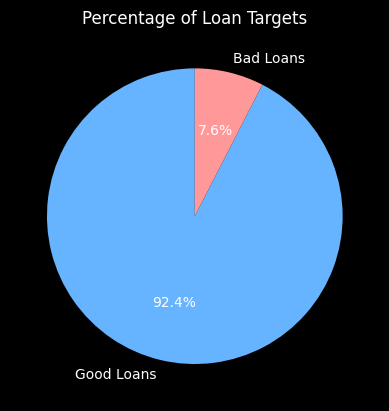

In [28]:
loan_target_counts = df['loan_target'].value_counts(normalize=True) * 100
loan_target_counts.plot(kind='pie', autopct='%1.1f%%', labels=['Good Loans', 'Bad Loans'], colors=['#66b3ff','#ff9999'], startangle=90)
plt.title('Percentage of Loan Targets')
plt.ylabel('')
plt.show()

### Lab Model

Split Data

In [29]:
from sklearn.model_selection import train_test_split

# Define features and target
X = df.drop(['loan_target'], axis=1)
y = df['loan_target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=99)

Create and train decision tree

In [30]:
from sklearn.ensemble import RandomForestClassifier

# Create and train the random forest classifier
clf = RandomForestClassifier(random_state=99, n_estimators=300, max_depth=15)
clf.fit(X_train, y_train)

# Predict on the test data
clf_y_pred = clf.predict(X_test)

Create dummy classifier

In [31]:
from sklearn.dummy import DummyClassifier

# Create and train the dummy classifier
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=99)
dummy_clf.fit(X_train, y_train)

# Predict on the test data
dummy_y_pred = dummy_clf.predict(X_test)

### Classification Report

In [32]:
from sklearn.metrics import classification_report

In [33]:
# Generate the classification report
report = classification_report(y_test, clf_y_pred, target_names=['Bad Loans', 'Good Loans'])
print(report)

              precision    recall  f1-score   support

   Bad Loans       1.00      0.41      0.58       778
  Good Loans       0.95      1.00      0.98      9222

    accuracy                           0.95     10000
   macro avg       0.98      0.71      0.78     10000
weighted avg       0.96      0.95      0.95     10000



In [34]:
# Evaluate the dummy classifier
dummy_report = classification_report(y_test, dummy_y_pred, target_names=['Bad Loans', 'Good Loans'], zero_division=0)
print(dummy_report)

              precision    recall  f1-score   support

   Bad Loans       0.00      0.00      0.00       778
  Good Loans       0.92      1.00      0.96      9222

    accuracy                           0.92     10000
   macro avg       0.46      0.50      0.48     10000
weighted avg       0.85      0.92      0.88     10000



List most important features

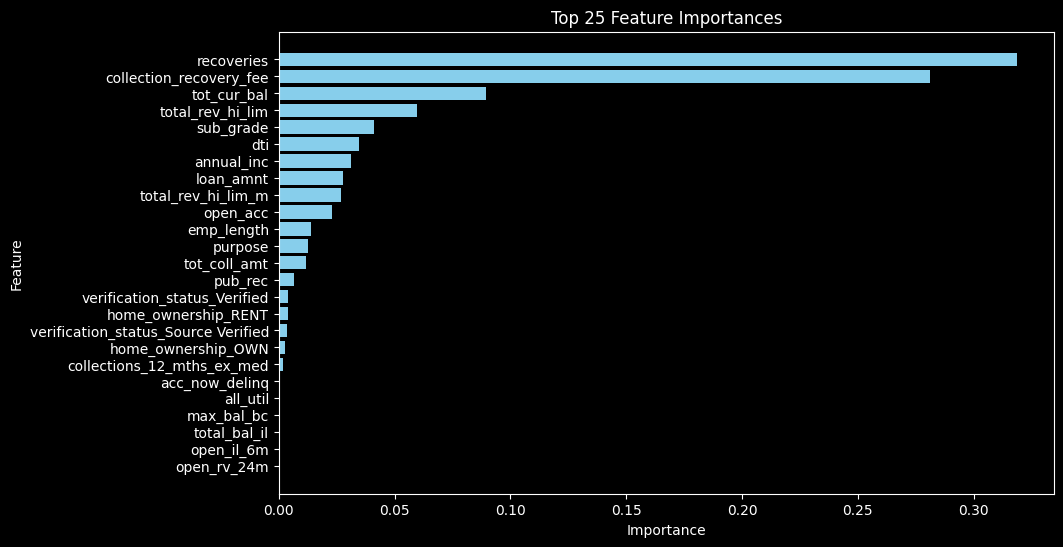

In [35]:
# Get feature importances
clf_importances = clf.feature_importances_
clf_feature_names = X.columns

# Create a DataFrame for visualization
clf_feature_importances = pd.DataFrame({'Feature': clf_feature_names, 'Importance': clf_importances})
clf_feature_importances = clf_feature_importances.sort_values(by='Importance', ascending=False).head(25)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(clf_feature_importances['Feature'], clf_feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 25 Feature Importances')
plt.gca().invert_yaxis()
plt.show()